### 6-2．データ準備
#### データの読み込み

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# Scikit-learnの読み込み
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

# ファイルの読み込み
dat_df = pd.read_csv('data/energydata.csv', sep=',')

# 先頭から5行目まで表示
dat_df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09


#### 欠損値の補完

In [2]:
# 欠損値を含む行を確認
dat_df[8585:8588]

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
8585,2016-03-11 07:50:00,70,0,20.2,37.160000,16.5,42.430000,20.39,37.500000,19.700000,34.360000,18.000000,46.660000
8586,2016-03-11 08:00:00,280,0,20.2,37.463333,16.6,42.766667,NaN,37.500000,19.700000,34.633333,18.066667,46.193333
8587,2016-03-11 08:10:00,180,10,20.2,37.530000,16.6,42.966667,20.29,37.363333,19.666667,34.723333,18.100000,45.723333


In [3]:
# 一つ前の行の値で補完
dat_df[8585:8588].fillna(method='ffill')

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
8585,2016-03-11 07:50:00,70,0,20.2,37.160000,16.5,42.430000,20.39,37.500000,19.700000,34.360000,18.000000,46.660000
8586,2016-03-11 08:00:00,280,0,20.2,37.463333,16.6,42.766667,20.39,37.500000,19.700000,34.633333,18.066667,46.193333
8587,2016-03-11 08:10:00,180,10,20.2,37.530000,16.6,42.966667,20.29,37.363333,19.666667,34.723333,18.100000,45.723333


In [4]:
# 欠損値を線形補完
dat_df = dat_df.interpolate()

# 欠損値を含む行を再確認
dat_df[8585:8588]

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
8585,2016-03-11 07:50:00,70,0,20.2,37.160000,16.5,42.430000,20.39,37.500000,19.700000,34.360000,18.000000,46.660000
8586,2016-03-11 08:00:00,280,0,20.2,37.463333,16.6,42.766667,20.34,37.500000,19.700000,34.633333,18.066667,46.193333
8587,2016-03-11 08:10:00,180,10,20.2,37.530000,16.6,42.966667,20.29,37.363333,19.666667,34.723333,18.100000,45.723333


#### 時間軸の作成

In [5]:
# dateをobject型からdatetime型へ変換
dat_df['date'] = pd.to_datetime(dat_df['date'], format='%Y-%m-%d %H:%M:%S')

# 前行との時間差を計算
dat_df['dif_min'] = dat_df['date'].diff().dt.total_seconds()/60
# 先頭要素の欠損を0埋め
dat_df['dif_min'] = dat_df['dif_min'].fillna(0)

# 経過時間（分）の計算
dat_df['cum_min'] = dat_df['dif_min'].cumsum()

# 先頭から5行目まで表示
dat_df[['date', 'cum_min']].head()

,date,cum_min
0,2016-01-11 17:00:00,0.0
1,2016-01-11 17:10:00,10.0
2,2016-01-11 17:20:00,20.0
3,2016-01-11 17:30:00,30.0
4,2016-01-11 17:40:00,40.0


In [6]:
# 練習問題4
# 経過時間（6時間）の計算
dat_df['cum_6hour'] = (dat_df['cum_min']/360).round(2).astype(int)

# 時間IDの確認
print(dat_df['cum_6hour'].unique())
# 先頭から50行目まで表示
dat_df[['date', 'cum_min', 'cum_6hour']].head(50)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

,date,cum_min,cum_6hour
0,2016-01-11 17:00:00,0.0,0
1,2016-01-11 17:10:00,10.0,0
2,2016-01-11 17:20:00,20.0,0
3,2016-01-11 17:30:00,30.0,0
4,2016-01-11 17:40:00,40.0,0
5,2016-01-11 17:50:00,50.0,0
6,2016-01-11 18:00:00,60.0,0
7,2016-01-11 18:10:00,70.0,0
8,2016-01-11 18:20:00,80.0,0
9,2016-01-11 18:30:00,90.0,0


#### 特徴量の作成1

In [7]:
# 6時間ごとの平均値を計算
dat_df = dat_df.drop(['date', 'dif_min', 'cum_min'], axis=1)
dat_df_mean = dat_df.groupby('cum_6hour').mean()

# データセットのサイズ確認
print(dat_df_mean.shape)
# 先頭から5行目まで表示
dat_df_mean.head()

(484, 12)


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
cum_6hour,,,,,,,,,,,,
0,150.000000,31.944444,20.688056,47.345394,20.023148,44.973287,20.111481,46.041875,19.255972,47.379074,17.761597,60.359861
1,81.944444,7.222222,20.858287,45.627708,20.227315,44.286435,20.213588,45.530833,20.740093,46.503634,18.898519,50.261273
2,83.333333,5.555556,19.860463,47.019213,19.140608,44.876698,20.149722,45.269306,19.349259,45.893611,18.163125,50.817454
3,101.111111,0.000000,20.037500,44.843009,19.103377,43.495476,19.907778,44.802407,19.748287,43.536204,17.835370,50.444111
4,78.611111,7.222222,19.947963,43.275394,19.113860,42.606633,19.788704,44.312037,19.555093,42.804491,17.477870,50.732546


In [8]:
# 練習問題5
# 6時間ごとの標準偏差を計算
dat_df_std = dat_df.groupby('cum_6hour').std()

# データセットのサイズ確認
print(dat_df_std.shape)
# 先頭から5行目まで表示
dat_df_std.head()

(484, 12)


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
cum_6hour,,,,,,,,,,,,
0,131.366445,13.901582,0.672443,2.998070,0.653222,0.848637,0.278809,1.185530,0.485747,1.282966,0.791008,9.891611
1,101.497908,9.137399,0.460572,0.811346,0.476669,0.342190,0.082826,0.103003,0.560148,0.511257,0.272610,0.339389
2,104.853639,9.085135,0.103157,1.039938,0.167655,0.318816,0.142110,0.261039,0.273491,0.776746,0.178471,1.138170
3,95.999339,0.000000,0.059026,1.091231,0.069944,0.617057,0.046289,0.068936,0.274278,0.622986,0.164863,0.792715
4,83.773599,12.097488,0.151195,0.561101,0.187641,0.418215,0.048003,0.180349,0.341428,0.430826,0.075740,0.247231


In [9]:
# 平均値と標準偏差データフレームをインデックスで結合
dat_features = pd.merge(dat_df_mean, dat_df_std, left_index=True, right_index=True)

# 
print(dat_features.shape)
# 先頭から5行目まで表示
dat_features.head()

(484, 24)


,Appliances_x,lights_x,T1_x,RH_1_x,T2_x,RH_2_x,T3_x,RH_3_x,T4_x,RH_4_x,...,T1_y,RH_1_y,T2_y,RH_2_y,T3_y,RH_3_y,T4_y,RH_4_y,T5_y,RH_5_y
cum_6hour,,,,,,,,,,,,,,,,,,,,,
0,150.000000,31.944444,20.688056,47.345394,20.023148,44.973287,20.111481,46.041875,19.255972,47.379074,...,0.672443,2.998070,0.653222,0.848637,0.278809,1.185530,0.485747,1.282966,0.791008,9.891611
1,81.944444,7.222222,20.858287,45.627708,20.227315,44.286435,20.213588,45.530833,20.740093,46.503634,...,0.460572,0.811346,0.476669,0.342190,0.082826,0.103003,0.560148,0.511257,0.272610,0.339389
2,83.333333,5.555556,19.860463,47.019213,19.140608,44.876698,20.149722,45.269306,19.349259,45.893611,...,0.103157,1.039938,0.167655,0.318816,0.142110,0.261039,0.273491,0.776746,0.178471,1.138170
3,101.111111,0.000000,20.037500,44.843009,19.103377,43.495476,19.907778,44.802407,19.748287,43.536204,...,0.059026,1.091231,0.069944,0.617057,0.046289,0.068936,0.274278,0.622986,0.164863,0.792715
4,78.611111,7.222222,19.947963,43.275394,19.113860,42.606633,19.788704,44.312037,19.555093,42.804491,...,0.151195,0.561101,0.187641,0.418215,0.048003,0.180349,0.341428,0.430826,0.075740,0.247231


#### 目的変数の作成

In [10]:
# ファイルの読み込み
event_df = pd.read_csv('data/event.csv', sep=',')

# 先頭から5行目まで表示
event_df.head()

,date
0,2016-01-12 10:00:00
1,2016-01-13 21:00:00
2,2016-01-14 10:00:00
3,2016-01-14 16:00:00
4,2016-01-14 17:00:00


In [11]:
import datetime as dt

# dateをobject型からdatetime型へ変換
event_df['date'] = pd.to_datetime(event_df['date'], format='%Y-%m-%d %H:%M:%S')

# 基準日時を説明変数のセットに合わせる
base_time = '2016-01-11 17:00:00'
# 各日時の基準日時からの差を計算
event_df['dif_min'] = event_df['date'] - dt.datetime.strptime(base_time, '%Y-%m-%d %H:%M:%S')
event_df['dif_min'] = event_df['dif_min'].dt.total_seconds()/60
# 6時間単位の時刻IDを計算
event_df['cum_6hour'] = (event_df['dif_min']/360).round(2).astype(int)

# 先頭から5行目まで表示
event_df.head()

,date,dif_min,cum_6hour
0,2016-01-12 10:00:00,1020.0,2
1,2016-01-13 21:00:00,3120.0,8
2,2016-01-14 10:00:00,3900.0,10
3,2016-01-14 16:00:00,4260.0,11
4,2016-01-14 17:00:00,4320.0,12


In [12]:
# 異常が発生したとしてフラグ1を立てる
event_df['event'] = 1

# cum_6hourとeventのみ抽出
event_df = event_df[['cum_6hour', 'event']]
event_df = event_df[~event_df.duplicated()]

# cum_6hourをインデックス化
event_df = event_df.set_index(['cum_6hour'])

# 先頭から5行目まで表示
event_df.head()

,event
cum_6hour,
2,1
8,1
10,1
11,1
12,1


In [13]:
# 特徴量と目的変数をインデックスで結合
dat_event = dat_features.join(event_df, how='left')
dat_event = dat_event.fillna(0)

# データセットのサイズを確認
print(dat_event.shape)
# 先頭から5行目まで表示
dat_event.head()

(484, 25)


,Appliances_x,lights_x,T1_x,RH_1_x,T2_x,RH_2_x,T3_x,RH_3_x,T4_x,RH_4_x,...,RH_1_y,T2_y,RH_2_y,T3_y,RH_3_y,T4_y,RH_4_y,T5_y,RH_5_y,event
cum_6hour,,,,,,,,,,,,,,,,,,,,,
0,150.000000,31.944444,20.688056,47.345394,20.023148,44.973287,20.111481,46.041875,19.255972,47.379074,...,2.998070,0.653222,0.848637,0.278809,1.185530,0.485747,1.282966,0.791008,9.891611,0.0
1,81.944444,7.222222,20.858287,45.627708,20.227315,44.286435,20.213588,45.530833,20.740093,46.503634,...,0.811346,0.476669,0.342190,0.082826,0.103003,0.560148,0.511257,0.272610,0.339389,0.0
2,83.333333,5.555556,19.860463,47.019213,19.140608,44.876698,20.149722,45.269306,19.349259,45.893611,...,1.039938,0.167655,0.318816,0.142110,0.261039,0.273491,0.776746,0.178471,1.138170,1.0
3,101.111111,0.000000,20.037500,44.843009,19.103377,43.495476,19.907778,44.802407,19.748287,43.536204,...,1.091231,0.069944,0.617057,0.046289,0.068936,0.274278,0.622986,0.164863,0.792715,0.0
4,78.611111,7.222222,19.947963,43.275394,19.113860,42.606633,19.788704,44.312037,19.555093,42.804491,...,0.561101,0.187641,0.418215,0.048003,0.180349,0.341428,0.430826,0.075740,0.247231,0.0


#### 特徴量の作成2

In [14]:
# 最初の6時間をデータセットとする
tmp = dat_df[dat_df['cum_6hour'] == 0]
# cum_6hour項目を除外
tmp = tmp.drop(['cum_6hour'], axis=1)

# スライド窓の平均値を計算
tmp = tmp.rolling(6).mean()
tmp = tmp.dropna()

# 窓ごとの特徴量を確認
tmp

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
5,55.000000,35.000000,19.890000,46.502778,19.200000,44.626528,19.790000,44.897778,18.932778,45.738750,17.166667,55.116667
6,55.000000,38.333333,19.890000,46.197778,19.200000,44.578194,19.790000,44.926111,18.914444,45.775972,17.155556,55.077778
7,55.000000,41.666667,19.884444,46.008889,19.200000,44.541111,19.780000,44.944444,18.896111,45.754444,17.144444,55.027778
8,56.666667,43.333333,19.867778,45.891806,19.200000,44.508889,19.770000,44.920556,18.890000,45.737778,17.144444,55.012778
9,60.000000,43.333333,19.862222,45.895694,19.205000,44.477222,19.770000,44.897778,18.890000,45.800000,17.133333,54.997778
10,88.333333,48.333333,19.868333,45.817361,19.231111,44.455556,19.770000,44.881111,18.890000,45.950000,17.116667,54.982778
11,176.666667,51.666667,19.897778,45.879028,19.268889,44.438889,19.770000,44.863333,18.908333,46.066667,17.111111,54.977778
12,238.333333,51.666667,19.938333,46.251250,19.330000,44.422222,19.786667,44.863333,18.926667,46.162222,17.111111,54.998333
13,270.000000,50.000000,20.005556,47.445694,19.418333,44.522222,19.813333,44.962222,18.945000,46.388889,17.111111,55.042222
14,276.666667,45.000000,20.111667,49.161667,19.527778,44.755556,19.863889,45.418333,18.963333,46.873333,17.100000,55.125556


In [15]:
import numpy as np

# 特徴量を結合
tmp2 = (np.array(tmp['Appliances']).tolist() + np.array(tmp['lights']).tolist() + 
        np.array(tmp['T1']).tolist() + np.array(tmp['RH_1']).tolist() + 
        np.array(tmp['T2']).tolist() + np.array(tmp['RH_2']).tolist() + 
        np.array(tmp['T3']).tolist() + np.array(tmp['RH_3']).tolist() + 
        np.array(tmp['T4']).tolist() + np.array(tmp['RH_4']).tolist() + 
        np.array(tmp['T5']).tolist() + np.array(tmp['RH_5']).tolist())

# 特徴量の長さを確認
print(len(tmp2))
# 特徴量を行方向へ並べて確認
pd.DataFrame(tmp2).T

372


,0,1,2,3,4,5,6,7,8,9,...,362,363,364,365,366,367,368,369,370,371
0,55.0,55.0,55.0,56.666667,60.0,88.333333,176.666667,238.333333,270.0,276.666667,...,78.903333,76.02,72.648889,69.037778,64.516667,59.767222,56.83,55.170417,53.997083,53.129306


In [16]:
# 練習問題6
# 6時間単位の時間IDを取得
hid = dat_df['cum_6hour'].unique()

# スライド窓の特徴量を格納
dat_slide_features = []

for i in range(len(hid)):
    # 6時間単位のデータセットを取得
    tmp = dat_df[dat_df['cum_6hour'] == i]
    # cum_6hour項目を除外
    tmp = tmp.drop(['cum_6hour'], axis=1)

    # スライド窓の平均値を計算
    tmp_mean = tmp.rolling(6).mean()
    tmp_mean = tmp_mean.dropna()
    # スライド窓の標準偏差を計算
    tmp_std = tmp.rolling(6).mean()
    tmp_std = tmp_std.dropna()    

    # 特徴量を結合
    tmp2 = (np.array(tmp_mean['Appliances']).tolist() + np.array(tmp_mean['lights']).tolist() + 
            np.array(tmp_mean['T1']).tolist() + np.array(tmp_mean['RH_1']).tolist() + 
            np.array(tmp_mean['T2']).tolist() + np.array(tmp_mean['RH_2']).tolist() + 
            np.array(tmp_mean['T3']).tolist() + np.array(tmp_mean['RH_3']).tolist() + 
            np.array(tmp_mean['T4']).tolist() + np.array(tmp_mean['RH_4']).tolist() + 
            np.array(tmp_mean['T5']).tolist() + np.array(tmp_mean['RH_5']).tolist() + 
            np.array(tmp_std['Appliances']).tolist() + np.array(tmp_std['lights']).tolist() + 
            np.array(tmp_std['T1']).tolist() + np.array(tmp_std['RH_1']).tolist() + 
            np.array(tmp_std['T2']).tolist() + np.array(tmp_std['RH_2']).tolist() + 
            np.array(tmp_std['T3']).tolist() + np.array(tmp_std['RH_3']).tolist() + 
            np.array(tmp_std['T4']).tolist() + np.array(tmp_std['RH_4']).tolist() + 
            np.array(tmp_std['T5']).tolist() + np.array(tmp_std['RH_5']).tolist())

    dat_slide_features.append(tmp2)

In [17]:
# 特徴量をデータフレームへ変換
dat_slide_features = pd.DataFrame(dat_slide_features)

# データセットのサイズを確認
print(dat_slide_features.shape)
# データセットの先頭5行まで確認
dat_slide_features.head()

(484, 744)


,0,1,2,3,4,5,6,7,8,9,...,734,735,736,737,738,739,740,741,742,743
0,55.000000,55.000000,55.000000,56.666667,60.000000,88.333333,176.666667,238.333333,270.000000,276.666667,...,78.903333,76.020000,72.648889,69.037778,64.516667,59.767222,56.830000,55.170417,53.997083,53.129306
1,56.666667,53.333333,48.333333,46.666667,43.333333,85.000000,141.666667,198.333333,255.000000,268.333333,...,50.090000,50.080000,50.065000,50.050000,50.035000,50.020000,50.005000,50.000000,50.000000,50.000000
2,43.333333,43.333333,46.666667,46.666667,45.000000,41.666667,40.000000,38.333333,35.000000,38.333333,...,52.633333,52.572222,52.305556,51.950000,51.473333,50.951111,50.407778,49.995556,49.783333,49.640000
3,55.000000,56.666667,80.000000,108.333333,126.666667,181.666667,186.666667,186.666667,203.333333,188.333333,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.010000,51.010000,51.010000,51.004444,50.987778
4,218.333333,221.666667,226.666667,203.333333,146.666667,91.666667,58.333333,53.333333,46.666667,45.000000,...,50.601111,50.536111,50.481111,50.437222,50.397222,50.362222,50.338889,50.350000,50.371667,50.427778


In [18]:
# 特徴量と目的変数を結合
tmp3 = dat_event[['event']]
dat_event2 = pd.concat([dat_slide_features, tmp3], axis=1)

# データセットのサイズを確認
print(dat_event2.shape)
# データセットの先頭5行まで確認
dat_event2.head()

(484, 745)


,0,1,2,3,4,5,6,7,8,9,...,735,736,737,738,739,740,741,742,743,event
0,55.000000,55.000000,55.000000,56.666667,60.000000,88.333333,176.666667,238.333333,270.000000,276.666667,...,76.020000,72.648889,69.037778,64.516667,59.767222,56.830000,55.170417,53.997083,53.129306,0.0
1,56.666667,53.333333,48.333333,46.666667,43.333333,85.000000,141.666667,198.333333,255.000000,268.333333,...,50.080000,50.065000,50.050000,50.035000,50.020000,50.005000,50.000000,50.000000,50.000000,0.0
2,43.333333,43.333333,46.666667,46.666667,45.000000,41.666667,40.000000,38.333333,35.000000,38.333333,...,52.572222,52.305556,51.950000,51.473333,50.951111,50.407778,49.995556,49.783333,49.640000,1.0
3,55.000000,56.666667,80.000000,108.333333,126.666667,181.666667,186.666667,186.666667,203.333333,188.333333,...,51.000000,51.000000,51.000000,51.000000,51.010000,51.010000,51.010000,51.004444,50.987778,0.0
4,218.333333,221.666667,226.666667,203.333333,146.666667,91.666667,58.333333,53.333333,46.666667,45.000000,...,50.536111,50.481111,50.437222,50.397222,50.362222,50.338889,50.350000,50.371667,50.427778,0.0


In [19]:
# display(dat_event)
# display(dat_event2)

In [20]:
# # kfoldと木構造のランダム性の散らばりを調査

# # データセットを説明変数と目的変数へ分割
# X = np.array(dat_event.drop('event', axis=1))
# Y = np.array(dat_event['event'])

# for i in range(10):
#     print('\n{}回目'.format(i))
#     # K-Fold交差検定
#     kf = KFold(n_splits=10, shuffle=True)
#     # モデル精度を格納する準備
#     scores = []
#     # データをシャッフルし、訓練データとテストデータに分割
#     for train_id, test_id in kf.split(X):
#         # 訓練データを使ってモデルを作成
#         x = X[train_id]
#         y = Y[train_id]
#         clf = tree.DecisionTreeClassifier()
#         clf.fit(x,y)
#         # テストデータにモデルを適用
#         pred_y = clf.predict(X[test_id])
#         # モデル精度を計算して格納
#         score = accuracy_score(Y[test_id], pred_y)
#         scores.append(score)

#     # モデルの平均精度、標準偏差を確認
#     scores = np.array(scores)
#     print(scores.mean(), scores.std())

#     # 再現率、適合率の確認
#     #print(confusion_matrix(Y[test_id], pred_y))
#     print(recall_score(Y[test_id], pred_y))
#     print(precision_score(Y[test_id], pred_y))

In [21]:
# # kfoldと木構造のランダム性の散らばりを調査

# # データセットを説明変数と目的変数へ分割
# X = np.array(dat_event2.drop('event', axis=1))
# Y = np.array(dat_event2['event'])

# for i in range(10):
#     print('\n{}回目'.format(i))
#     # K-Fold交差検定
#     kf = KFold(n_splits=10, shuffle=True)
#     # モデル精度を格納する準備
#     scores = []
#     # データをシャッフルし、訓練データとテストデータに分割
#     for train_id, test_id in kf.split(X):
#         # 訓練データを使ってモデルを作成
#         x = X[train_id]
#         y = Y[train_id]
#         clf = tree.DecisionTreeClassifier()
#         clf.fit(x,y)
#         # テストデータにモデルを適用
#         pred_y = clf.predict(X[test_id])
#         # モデル精度を計算して格納
#         score = accuracy_score(Y[test_id], pred_y)
#         scores.append(score)

#     # モデルの平均精度、標準偏差を確認
#     scores = np.array(scores)
#     print(scores.mean(), scores.std())

#     # 再現率、適合率の確認
#     #print(confusion_matrix(Y[test_id], pred_y))
#     print(recall_score(Y[test_id], pred_y))
#     print(precision_score(Y[test_id], pred_y))

In [22]:
# 特徴量１で分類

# データセットを説明変数と目的変数へ分割
X = np.array(dat_event.drop('event', axis=1))
Y = np.array(dat_event['event'])

# K-Fold交差検定
kf = KFold(n_splits=10, shuffle=True, random_state=2020)
# モデル精度を格納する準備
scores = []
# データをシャッフルし、訓練データとテストデータに分割
for train_id, test_id in kf.split(X):
    # 訓練データを使ってモデルを作成
    x = X[train_id]
    y = Y[train_id]
    clf = tree.DecisionTreeClassifier(random_state=2020)
    clf.fit(x,y)
    # テストデータにモデルを適用
    pred_y = clf.predict(X[test_id])
    # モデル精度を計算して格納
    score = accuracy_score(Y[test_id], pred_y)
    scores.append(score)

# モデルの平均精度、標準偏差を確認
scores = np.array(scores)
print(scores.mean(), scores.std())

# 再現率、適合率の確認
#print(confusion_matrix(Y[test_id], pred_y))
print(recall_score(Y[test_id], pred_y))
print(precision_score(Y[test_id], pred_y))

# モデル作成パラメータの確認
print(clf)

# パラメータ範囲設定
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [10, 20, 30, 40, 50],
}

# グリッドサーチの実行条件セット
clf_gs = GridSearchCV(tree.DecisionTreeClassifier(), params, 
                      cv=KFold(n_splits=10, shuffle=True), scoring='accuracy')

# グリッドサーチの実行
clf_gs.fit(X, Y)

# 最も高い精度とパラメータの組合せを表示
print(clf_gs.best_score_)
print(clf_gs.best_params_)

# 最適なパラメータを使ってモデル作成
clf_best = tree.DecisionTreeClassifier(
    criterion='entropy', max_depth=10, min_samples_leaf=20)
clf_best.fit(X, Y)

# 影響の高い変数を確認
# print(clf_best.feature_importances_)
feature = clf_best.feature_importances_

for i in range(len(feature)):
    print(np.argsort(feature)[::-1][i], np.sort(feature)[::-1][i])

0.905017006802721 0.02771260982145664
0.7142857142857143
1.0
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
0.9442602040816326
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}
12 0.8703046718520628
15 0.10296028714770901
7 0.026735041000228124
23 0.0
10 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
8 0.0
9 0.0
11 0.0
22 0.0
13 0.0
14 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
0 0.0


In [23]:
# 特徴量２で分類

# データセットを説明変数と目的変数へ分割
X = np.array(dat_event2.drop('event', axis=1))
Y = np.array(dat_event2['event'])

# K-Fold交差検定
kf = KFold(n_splits=10, shuffle=True, random_state=2020)
# モデル精度を格納する準備
scores = []
# データをシャッフルし、訓練データとテストデータに分割
for train_id, test_id in kf.split(X):
    # 訓練データを使ってモデルを作成
    x = X[train_id]
    y = Y[train_id]
    clf = tree.DecisionTreeClassifier(random_state=2020)
    clf.fit(x,y)
    # テストデータにモデルを適用
    pred_y = clf.predict(X[test_id])
    # モデル精度を計算して格納
    score = accuracy_score(Y[test_id], pred_y)
    scores.append(score)

# モデルの平均精度、標準偏差を確認
scores = np.array(scores)
print(scores.mean(), scores.std())

# 再現率、適合率の確認
#print(confusion_matrix(Y[test_id], pred_y))
print(recall_score(Y[test_id], pred_y))
print(precision_score(Y[test_id], pred_y))

# モデル作成パラメータの確認
print(clf)

# パラメータ範囲設定
params = {
    'criterion': ['gini', 'entropy'],    
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [10, 20, 30, 40, 50],
}

# グリッドサーチの実行条件セット
clf_gs = GridSearchCV(tree.DecisionTreeClassifier(), params, 
                      cv=KFold(n_splits=10, shuffle=True), scoring='accuracy')

# グリッドサーチの実行
clf_gs.fit(X, Y)

# 最も高い精度とパラメータの組合せを表示
print(clf_gs.best_score_)
print(clf_gs.best_params_)

# 最適なパラメータを使ってモデル作成
clf_best = tree.DecisionTreeClassifier(
    criterion='entropy', max_depth=10, min_samples_leaf=20)
clf_best.fit(X, Y)

# 影響の高い変数を確認
# print(clf_best.feature_importances_)
feature = clf_best.feature_importances_

for i in range(len(feature)):
    print(np.argsort(feature)[::-1][i], np.sort(feature)[::-1][i])

0.8947704081632653 0.029323945994936675
0.7142857142857143
0.7692307692307693
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
0.9109693877551021
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}
389 0.4262251226104558
7 0.20042988878454443
401 0.1461102284487595
14 0.048864668633721554
4 0.04777261367278326
432 0.0424877152813848
402 0.031987921699845774
388 0.030914917848226586
374 0.02520692302027814
743 0.0
252 0.0
251 0.0
250 0.0
249 0.0
248 0.0
247 0.0
245 0.0
246 0.0
254 0.0
244 0.0
243 0.0
242 0.0
241 0.0
240 0.0
239 0.0
238 0.0
237 0.0
236 0.0
253 0.0
258 0.0
255 0.0
267 0.0
276 0.0
275 0.0
274

In [24]:
# 特徴量１と２で分類

# データセットを説明変数と目的変数へ分割
X1 = dat_event.drop('event', axis=1)

X2 = dat_event2.drop('event', axis=1)

X = np.array(pd.concat([X1, X2], axis=1))
Y = np.array(dat_event2['event'])

# K-Fold交差検定
kf = KFold(n_splits=10, shuffle=True, random_state=2020)
# モデル精度を格納する準備
scores = []
# データをシャッフルし、訓練データとテストデータに分割
for train_id, test_id in kf.split(X):
    # 訓練データを使ってモデルを作成
    x = X[train_id]
    y = Y[train_id]
    clf = tree.DecisionTreeClassifier(random_state=2020)
    clf.fit(x,y)
    # テストデータにモデルを適用
    pred_y = clf.predict(X[test_id])
    # モデル精度を計算して格納
    score = accuracy_score(Y[test_id], pred_y)
    scores.append(score)

# モデルの平均精度、標準偏差を確認
scores = np.array(scores)
print(scores.mean(), scores.std())

# 再現率、適合率の確認
#print(confusion_matrix(Y[test_id], pred_y))
print(recall_score(Y[test_id], pred_y))
print(precision_score(Y[test_id], pred_y))

# モデル作成パラメータの確認
print(clf)

# パラメータ範囲設定
params = {
    'criterion': ['gini', 'entropy'],    
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [10, 20, 30, 40, 50],
}

# グリッドサーチの実行条件セット
clf_gs = GridSearchCV(tree.DecisionTreeClassifier(), params, 
                      cv=KFold(n_splits=10, shuffle=True), scoring='accuracy')

# グリッドサーチの実行
clf_gs.fit(X, Y)

# 最も高い精度とパラメータの組合せを表示
print(clf_gs.best_score_)
print(clf_gs.best_params_)

0.9174319727891156 0.022135645711181588
0.7857142857142857
1.0
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
0.9358843537414966
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 20}


In [25]:
# 最適なパラメータを使ってモデル作成
clf_best = tree.DecisionTreeClassifier(
    criterion='gini', max_depth=4, min_samples_leaf=10, random_state=2020)
clf_best.fit(X, Y)

# 影響の高い変数を確認
# print(clf_best.feature_importances_)
feature = clf_best.feature_importances_

for i in range(len(feature)):
    print(np.argsort(feature)[::-1][i], np.sort(feature)[::-1][i])

12 0.8888212078323845
455 0.04696864596672876
15 0.027034771794905574
301 0.017496715528839316
619 0.01337984128675949
712 0.006298817590382149
242 0.0
260 0.0
259 0.0
258 0.0
257 0.0
256 0.0
255 0.0
254 0.0
253 0.0
251 0.0
252 0.0
262 0.0
250 0.0
249 0.0
248 0.0
247 0.0
246 0.0
245 0.0
244 0.0
243 0.0
261 0.0
767 0.0
263 0.0
274 0.0
283 0.0
282 0.0
281 0.0
280 0.0
279 0.0
278 0.0
277 0.0
276 0.0
275 0.0
273 0.0
240 0.0
272 0.0
271 0.0
270 0.0
269 0.0
268 0.0
267 0.0
266 0.0
265 0.0
264 0.0
241 0.0
238 0.0
239 0.0
204 0.0
213 0.0
212 0.0
211 0.0
210 0.0
209 0.0
208 0.0
207 0.0
206 0.0
205 0.0
203 0.0
215 0.0
202 0.0
201 0.0
200 0.0
199 0.0
198 0.0
197 0.0
196 0.0
195 0.0
194 0.0
214 0.0
216 0.0
285 0.0
228 0.0
237 0.0
236 0.0
235 0.0
234 0.0
233 0.0
232 0.0
231 0.0
230 0.0
229 0.0
227 0.0
217 0.0
226 0.0
225 0.0
224 0.0
223 0.0
222 0.0
221 0.0
220 0.0
219 0.0
218 0.0
284 0.0
288 0.0
286 0.0
346 0.0
355 0.0
354 0.0
353 0.0
352 0.0
351 0.0
350 0.0
349 0.0
348 0.0
347 0.0
345 0.0
357 0.0


In [41]:
# 特徴量を5つ選択
selector = SelectKBest(k=5) 
selector.fit(X, Y)
mask = selector.get_support()

# どの変数を選択したかを確認
print(pd.concat([X1, X2], axis=1).columns)
for i, boolean in enumerate(mask):
    if boolean:
        print(i)

Index(['Appliances_x',     'lights_x',         'T1_x',       'RH_1_x',
               'T2_x',       'RH_2_x',         'T3_x',       'RH_3_x',
               'T4_x',       'RH_4_x',
       ...
                  734,            735,            736,            737,
                  738,            739,            740,            741,
                  742,            743],
      dtype='object', length=768)
0
12
32
403
404


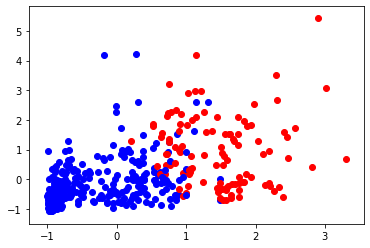

In [46]:
# 特徴量１と２で分類で有効の特徴量だけを見てみる

# データセットを説明変数と目的変数へ分割
X1 = dat_event.drop('event', axis=1)

X2 = dat_event2.drop('event', axis=1)

df_X = pd.concat([X1, X2], axis=1)
df_Y = dat_event2['event']

X = np.array(df_X)
Y = np.array(df_Y)
std = StandardScaler()
X_std = std.fit_transform(X)

# X_std = X

for i, d in enumerate(df_Y.values):
    if ( d == 0):
        plt.scatter(X_std[i][12], X_std[i][15], color='blue', label=0)
    else:
        plt.scatter(X_std[i][12], X_std[i][15], color='red', label=1)        

plt.show()
